In [33]:
import os
import torch
import argparse
import numpy as np

from engine.logger import Logger
from engine.solver import Trainer
from Data.build_dataloader import build_dataloader, build_dataloader_cond
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from Utils.io_utils import load_yaml_config, seed_everything, merge_opts_to_config, instantiate_from_config
from Utils.metric_utils import visualization

import sys
import time
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from tqdm import tqdm
from ema_pytorch import EMA
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from Utils.io_utils import instantiate_from_config, get_model_parameters_info


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 

import umap                        
import seaborn as sns 

from pypots.utils.metrics import calc_mse,calc_rmse,calc_mae
import random

In [34]:
def visualization2(ori, gen):
    
    Number = ori.shape[0]
    
    max_sample = min([4000, Number])       # 最多取4000个样本
    idx = np.random.permutation(Number)[ :max_sample]

    ori1 = np.asarray(ori)[idx]
    gen1 = np.asarray(gen)[idx]

    ori1 = np.mean(ori1, 2) 
    gen1 = np.mean(gen1, 2) 

    concat_data = np.concatenate((ori1, gen1), axis=0)
    
    pca = PCA(2)     
    pca_res = pca.fit_transform(concat_data)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500) 
    tsne_res = tsne.fit_transform(concat_data) 

    umap_ = umap.UMAP(random_state=42)
    umap_res = umap_.fit_transform(concat_data)
    
    
    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    
    plt.scatter(pca_res[:2000,0],pca_res[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res[max_sample:max_sample+2000,0],pca_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(a)',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(tsne_res[:2000,0],tsne_res[:2000,1],  s=15,  c='#ff7f0e')
    plt.scatter(tsne_res[max_sample:max_sample+2000,0],tsne_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(b)',fontsize=25)

    plt.subplot(1,4,3)
    plt.scatter(umap_res[:2000, 0], umap_res[:2000, 1],  cmap='Spectral', s=15,  c='#ff7f0e')
    plt.scatter(umap_res[max_sample:max_sample+2000, 0], umap_res[max_sample:max_sample+2000, 1],  cmap='Spectral', s=15, c='#1f77b4')
    plt.xlabel('(c)',fontsize=25)

    
    plt.subplot(1,4,4)
    sns.distplot(ori[:,:,1], hist=False, color = '#ff7f0e' )
    sns.distplot(gen[:,:,1], hist=False, color = '#1f77b4' )  
    plt.xlabel('(d)',fontsize=25)
    

In [35]:
def parse_args():
    parser = argparse.ArgumentParser(description='PyTorch Training Script')
    parser.add_argument('--name', type=str, default=None)

    parser.add_argument('--config_file', type=str, default=None, 
                        help='path of config file')
    parser.add_argument('--output', type=str, default='OUTPUT', 
                        help='directory to save the results')
    parser.add_argument('--tensorboard', action='store_true', 
                        help='use tensorboard for logging')

    # args for random

    parser.add_argument('--cudnn_deterministic', action='store_true', default=False,
                        help='set cudnn.deterministic True')
    parser.add_argument('--seed', type=int, default=10, 
                        help='seed for initializing training.')
    parser.add_argument('--gpu', type=int, default=None,
                        help='GPU id to use. If given, only the specific gpu will be'
                        ' used, and ddp will be disabled')
    
    # args for training
    parser.add_argument('--train', action='store_true', default=False, help='Train or Test.')
    parser.add_argument('--sample', type=int, default=0, 
                        choices=[0, 1], help='Condition or Uncondition.')
    parser.add_argument('--mode', type=str, default='infill',
                        help='Infilling or Forecasting.')
    parser.add_argument('--milestone', type=int, default=10)

    parser.add_argument('--missing_ratio', type=float, default=0., help='Ratio of Missing Values.')
    parser.add_argument('--pred_len', type=int, default=0, help='Length of Predictions.')
    
    
    # args for modify config
    parser.add_argument('opts', help='Modify config options using the command-line',
                        default=None, nargs=argparse.REMAINDER)  

    args = parser.parse_args(args=[])
    args.save_dir = os.path.join(args.output, f'{args.name}')

    return args


In [36]:
args = parse_args()

# data_name = 'ETTh1'
# data_name = 'Energy'
# data_name = 'weather'
data_name = 'exchange_rate'

if data_name == 'ETTh1':
    args.config_file =  './Config/ETTh1.yaml'

elif data_name == 'Energy':
    args.config_file =  './Config/Energy.yaml'

elif data_name == 'exchange_rate':
    args.config_file =  './Config/exchange_rate.yaml'
    
elif data_name == 'weather':
    args.config_file =  './Config/weather.yaml'
    
args.gpu =  0
args.train = True
print(args)

Namespace(name=None, config_file='./Config/exchange_rate.yaml', output='OUTPUT', tensorboard=False, cudnn_deterministic=False, seed=10, gpu=0, train=True, sample=0, mode='infill', milestone=10, missing_ratio=0.0, pred_len=0, opts=[], save_dir='OUTPUT\\None')


In [37]:
if args.seed is not None:
    seed_everything(args.seed)

if args.gpu is not None:
    torch.cuda.set_device(args.gpu)

config = load_yaml_config(args.config_file)
config = merge_opts_to_config(config, args.opts)


config['dataloader']['batch_size'] = 128
print(config)

beta_schedule = config['model']['params']['beta_schedule'] 
timesteps = config['model']['params']['timesteps'] 
print(beta_schedule, timesteps)

Global seed set to 10
{'model': {'target': 'Models.interpretable_diffusion.gaussian_diffusion.Diffusion_TS', 'params': {'seq_length': 24, 'feature_size': 8, 'n_layer_enc': 4, 'n_layer_dec': 3, 'd_model': 96, 'timesteps': 500, 'sampling_timesteps': 500, 'loss_type': 'l1', 'beta_schedule': 'cosine', 'n_heads': 4, 'mlp_hidden_times': 4, 'attn_pd': 0.0, 'resid_pd': 0.0, 'kernel_size': 1, 'padding_size': 0}}, 'solver': {'base_lr': 1e-05, 'max_epochs': 25000, 'results_folder': './Checkpoints_energy', 'gradient_accumulate_every': 2, 'save_cycle': 2500, 'ema': {'decay': 0.995, 'update_interval': 10}, 'scheduler': {'target': 'engine.lr_sch.ReduceLROnPlateauWithWarmup', 'params': {'factor': 0.5, 'patience': 5000, 'min_lr': 1e-05, 'threshold': 0.1, 'threshold_mode': 'rel', 'warmup_lr': 0.0008, 'warmup': 500, 'verbose': False}}}, 'dataloader': {'train_dataset': {'target': 'Utils.Data_utils.real_datasets.CustomDataset', 'params': {'name': 'energy', 'proportion': 1.0, 'data_root': './Data/datasets/e

In [38]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


if data_name == 'ETTh1':
    load_data = np.load( './Data/datasets/ETTh1.npy')
    
elif data_name == 'Energy':
    load_data = np.load( './Data/datasets/Energy.npy')

elif data_name == 'exchange_rate':
    load_data = np.load( './Data/datasets/exchange_rate.npy')
    
elif data_name == 'weather':
    load_data = np.load( './Data/datasets/weather.npy')
    
    

np.random.shuffle(load_data)

train_data = load_data
test_data = load_data
    
    
print(train_data.shape, test_data.shape)

Numble = train_data.shape[0]
Length = train_data.shape[1]
Feature = train_data.shape[2]
Batchsize = 200


class MyDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)  # 转换为 Tensor
        return x   
                    
dataset = MyDataset(train_data)    
dataloader = DataLoader(dataset, batch_size=Batchsize, shuffle=True)

def cycle(dl):         
    while True:
        for data in dl:
            yield data
            
dl = cycle( dataloader )
print( next(dl).shape )

(2522, 24, 8) (2522, 24, 8)
torch.Size([200, 24, 8])


In [39]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def exists(x):
    return x is not None

from Models.interpretable_diffusion.model_utils import default, identity, extract
from Models.interpretable_diffusion.gaussian_diffusion import linear_beta_schedule, cosine_beta_schedule, Diffusion_TS
import torch.nn.functional as F

shape = (Numble, Length, Feature)
print(shape)


(2522, 24, 8)


# training rectified flow

In [8]:
rf_model = instantiate_from_config(config['model']).cuda()
print(rf_model.use_ff, rf_model.num_timesteps, rf_model.loss_type)
print(rf_model.sampling_timesteps, rf_model.fast_sampling)

True 500 l1
500 False


In [40]:
device = rf_model.betas.device
epoch = 500
iteration = int( epoch * (Numble/Batchsize) )

gradient_accumulate_every = config['solver']['gradient_accumulate_every'] 

In [10]:
start_lr = config['solver'].get('base_lr', 1.0e-4)
ema_decay = config['solver']['ema']['decay']
ema_update_every = config['solver']['ema']['update_interval']
ema = EMA(rf_model, beta=ema_decay, update_every=ema_update_every).to(device)

opt = Adam(filter(lambda p: p.requires_grad, rf_model.parameters()), lr=start_lr, betas=[0.9, 0.96])

sc_cfg = config['solver']['scheduler']
sc_cfg['params']['optimizer'] = opt    
sch = instantiate_from_config(sc_cfg)   

In [41]:
ds = 1 / torch.tensor([2 ** i for i in range(1, 8)]).to(device)
ds_p = torch.ones((ds.shape[0],)).to(device) / ds.shape[0]

d = ds[ds_p.multinomial(10, replacement=True).to(device)]
t = torch.rand(size=(10, 1), device=device)

def reshape_coefs(t):
    return t.reshape((t.shape[0], 1,  1))


In [13]:
padding_masks = None
clip_x_start = False
clip_denoised = True

loss_list = []

pbar = tqdm( total=iteration )   

step = 0

while step < iteration:
    total_loss = 0.

    for _ in range(gradient_accumulate_every):
    
        x_1 = next(dl).to(device)          
        x_0 = torch.randn_like(x_1)
        b, c, n, = x_0.shape
        K = int(b * 1)

        t = torch.rand( size=(b,), device=device)      
        t_re = reshape_coefs(t)                               

        x_t = t_re * x_1 + (1. - t_re) * x_0     

        d = ds[ds_p.multinomial(b, replacement=True).to(device)]   
        d[:K] = 0  

        padding_masks = torch.ones(b, c, dtype=bool, device=x_t.device)
        
        v_pred = rf_model.output( x_t[:K], t[:K], d=d[:K], padding_masks=padding_masks) 
        
        fm_loss = F.mse_loss(v_pred, (x_1[:K] - x_0[:K]), reduction="mean")
    
        loss_list.append(fm_loss.item())
        
        fm_loss = fm_loss / gradient_accumulate_every
        fm_loss.backward()                      
        total_loss += fm_loss.item()
    
    
    clip_grad_norm_(rf_model.parameters(), 1.0)  
    opt.step()
    sch.step(total_loss)    
    opt.zero_grad()
    step += 1
    ema.update()  
    
    pbar.update(1)
    
pbar.close()

100%|████████████████████████████████████████████████████████████████████████████| 24942/24942 [50:28<00:00,  8.24it/s]


49884 0.18349984288215637
[0.47231512133739273, 0.39737895523099637, 0.4433260833743776, 0.43131763577468024, 0.39694827522208714, 0.41837743583040776, 0.42817957453700395, 0.4149535685727667, 0.43732716347988954, 0.41921908096715577]


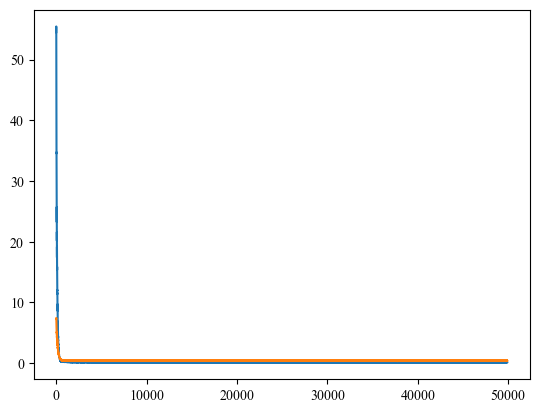

In [16]:
print(len(loss_list), total_loss)

rmse = list( map(lambda x: x ** (1/2), loss_list) )
print(rmse[-10:])

plt.figure()
plt.plot(loss_list)
plt.plot(rmse)

In [17]:

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/ETTh1_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/ETTh1_ema_rf.pth" )

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/Energy_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/Energy_ema_rf.pth" )

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/weather_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/weather_ema_rf.pth" )

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/exchange_rate_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/exchange_rate_ema_rf.pth" )

# load rectified flow

In [12]:
rf_model = instantiate_from_config(config['model']).cuda()

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_ema_rf.pth"  ))

rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_rf.pth"  ))
ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_ema_rf.pth"  ))


<All keys matched successfully>

# synthesis in large sampling step by rectified flow

In [13]:
n_steps = 30
eps = 1e-8
# eps = 0
shape = (Numble, Length, Feature)


x_t = torch.randn(shape, device=device)
b, c, n, = x_t.shape

padding_masks = torch.ones(b, c, dtype=bool, device=device)

d = ds[ds_p.multinomial(b, replacement=True).to(device)]
d[:b] = 0 
print( d.shape )


t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)
# print(len(t))

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
#     d_batch = d.unsqueeze(0).repeat((b,))
    
    with torch.no_grad():
        
        v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 

    x_t = x_t + (t[i] - t[i - 1]) * v_pred

print(x_t.shape)

torch.Size([2522])
torch.Size([2522, 24, 8])


In [42]:
# visualization2(train_data, x_t.detach().cpu().numpy() )

# synthesis in few-step by rectified flow

In [18]:
eps = 1e-8
shape = (Numble, Length, Feature)
b, c, n, = x_t.shape
padding_masks = torch.ones(b, c, dtype=bool, device=device)
d = ds[ds_p.multinomial(b, replacement=True).to(device)]
d[:b] = 0 

res_list = []
for n_steps in [1,3,5,10]:
    x_t = torch.randn(shape, device=device)
    
    t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)

    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))

        with torch.no_grad():

            v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 

        x_t = x_t + (t[i] - t[i - 1]) * v_pred
        
    res_list.append(x_t.detach().cpu().numpy())
print(len(res_list))

4


In [19]:
def visualization3(ori, gen):
    Number = ori.shape[0]
    max_sample = min([4000, Number])      
    idx = np.random.permutation(Number)[ :max_sample]
    
    ori1 = np.asarray(ori)[idx]
    ori1 = np.mean(ori1, 2) 
    
    gen1 = np.asarray(gen[0])[idx]
    gen2 = np.asarray(gen[1])[idx]
    gen3 = np.asarray(gen[2])[idx]
    gen4 = np.asarray(gen[3])[idx]
      
    gen1 = np.mean(gen1, 2) 
    gen2 = np.mean(gen2, 2) 
    gen3 = np.mean(gen3, 2) 
    gen4 = np.mean(gen4, 2) 

    concat_data1 = np.concatenate((ori1, gen1), axis=0)
    concat_data2 = np.concatenate((ori1, gen2), axis=0)
    concat_data3 = np.concatenate((ori1, gen3), axis=0)
    concat_data4 = np.concatenate((ori1, gen4), axis=0)
    
    pca = PCA(2)     
    pca_res1 = pca.fit_transform(concat_data1)
    pca = PCA(2)
    pca_res2 = pca.fit_transform(concat_data2)
    pca = PCA(2)
    pca_res3 = pca.fit_transform(concat_data3)
    pca = PCA(2)
    pca_res4 = pca.fit_transform(concat_data4)

    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    

    plt.scatter(pca_res1[:2000,0],pca_res1[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res1[max_sample:max_sample+2000,0],pca_res1[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(a)',fontsize=25)
#     plt.title('Step 1',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(pca_res2[:2000,0],pca_res2[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res2[max_sample:max_sample+2000,0],pca_res2[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(b)',fontsize=25)
#     plt.title('Step 3',fontsize=25)
    
    plt.subplot(1,4,3)
    plt.scatter(pca_res3[:2000,0],pca_res3[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res3[max_sample:max_sample+2000,0],pca_res3[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(c)',fontsize=25)
#     plt.title('Step 5',fontsize=25)
    
    plt.subplot(1,4,4)
    plt.scatter(pca_res4[:2000,0],pca_res4[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res4[max_sample:max_sample+2000,0],pca_res4[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(d)',fontsize=25)
#     plt.title('Step 10',fontsize=25)
    

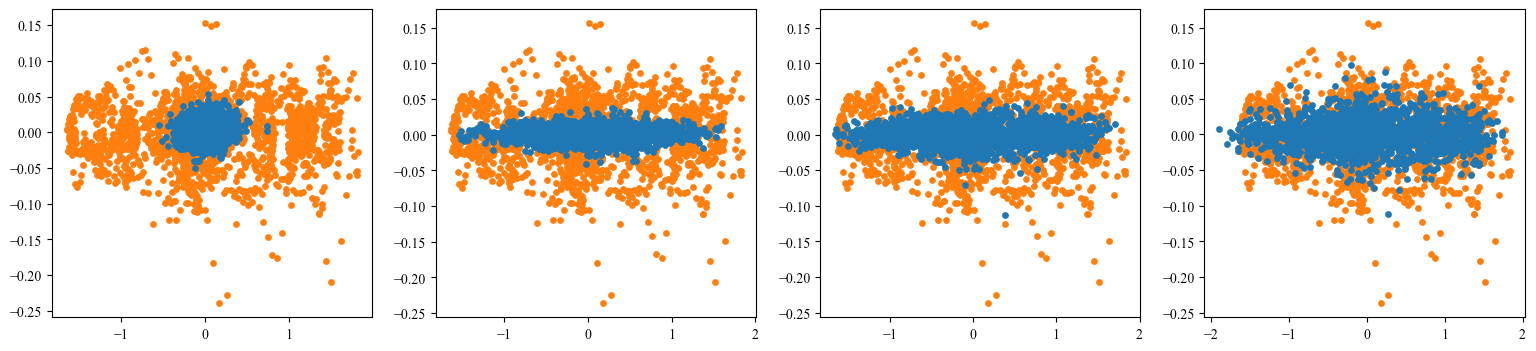

In [20]:
visualization3(train_data, res_list)

# training shortcut-ts

In [48]:
shortcut = instantiate_from_config(config['model']).cuda()

In [49]:
epoch = 500
iteration = int( epoch * (Numble/Batchsize) )
print(iteration)

device = shortcut.betas.device
gradient_accumulate_every = config['solver']['gradient_accumulate_every'] 

6305


In [50]:
start_lr = config['solver'].get('base_lr', 1.0e-4)
ema_decay = config['solver']['ema']['decay']
ema_update_every = config['solver']['ema']['update_interval']
ema = EMA(shortcut, beta=ema_decay, update_every=ema_update_every).to(device)

opt = Adam(filter(lambda p: p.requires_grad, shortcut.parameters()), lr=start_lr, betas=[0.9, 0.96])


sc_cfg = config['solver']['scheduler']
sc_cfg['params']['optimizer'] = opt    
sch = instantiate_from_config(sc_cfg)   

In [51]:
ds = 1 / torch.tensor([2 ** i for i in range(1, 8)]).to(device)
ds_p = torch.ones((ds.shape[0],)).to(device) / ds.shape[0]

d = ds[ds_p.multinomial(5, replacement=True).to(device)]
t = torch.rand(size=(10, 1), device=device)

def reshape_coefs(t):
    return t.reshape((t.shape[0], 1,  1))

K = int(Batchsize * 0.75)

In [52]:
padding_masks = None
clip_x_start = False
clip_denoised = True

loss_fm = []
loss_consis = []
loss_total = []

pbar = tqdm( total=iteration )   

step = 0
while step < iteration:
    total_loss = 0.

    for _ in range(gradient_accumulate_every):
    
        x_1 = next(dl).to(device)          
        x_0 = torch.randn_like(x_1)
        b, c, n, = x_0.shape
        K = int(b * 0.75)

        t = torch.rand( size=(b,), device=device)     
        t_re = reshape_coefs(t)                               

        x_t = t_re * x_1 + (1. - t_re) * x_0    

        d = ds[ds_p.multinomial(b, replacement=True).to(device)]   #
        d[:K] = 0  

        padding_masks = torch.ones(b, c, dtype=bool, device=x_t.device)
            
            
        v_pred = shortcut.output( x_t[:K], t[:K], d=d[:K], padding_masks=padding_masks[:K]) 

        
        
        fm_loss = F.mse_loss(v_pred, (x_1[:K] - x_0[:K]), reduction="mean")

        s_t =  shortcut.output( x_t[K:], t[K:], d=d[K:], padding_masks=padding_masks[K:]) 
        
        d_re = reshape_coefs(d[K:])  

        x_td = x_t[K:] + s_t * d_re

        s_td = shortcut.output( x_td, t[K:]+ d[K:], d=d[K:], padding_masks=padding_masks[K:]) 
        s_target = (s_t + s_td) / 2 
    
    
    
        v_pred_2 = shortcut.output( x_t[K:], t[K:], d=2*d[K:], padding_masks=padding_masks[K:]) 
    
        consistency_loss = F.mse_loss(v_pred_2, s_target, reduction="mean")
    
        loss = fm_loss + consistency_loss
    
    
        loss_total.append(loss.item())
        loss_fm.append(fm_loss.item())
        loss_consis.append(consistency_loss.item())
        
        
        loss = loss / gradient_accumulate_every
        loss.backward()                     
        total_loss += loss.item()
    
    
    clip_grad_norm_(shortcut.parameters(), 1.0)  
    opt.step()
    sch.step(total_loss)    
    opt.zero_grad()
    step += 1
    ema.update()  
    
    pbar.update(1)
    
pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 6305/6305 [27:57<00:00,  3.76it/s]


[0.2109082607914441, 0.25024845770856985, 0.22554137049777168, 0.24488436519673945, 0.2448556804489015, 0.22477246873054219, 0.230714448792378, 0.2391491000702874, 0.2162560857759911, 0.24372935941309054]
[0.0007232326897792518, 0.0005399400251917541, 0.000737006077542901, 0.0007189317839220166, 0.000869407900609076, 0.0009532634867355227, 0.0005838873912580311, 0.0008901159162633121, 0.0010068058036267757, 0.0005147839547134936]


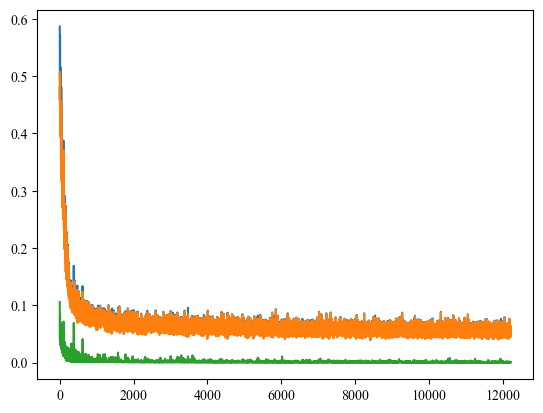

In [53]:
rmse = list( map(lambda x: x ** (1/2), loss_fm) )
print(rmse[-10:])

print( loss_consis[-10:])

plt.figure()
plt.plot(loss_total[400:])

# plt.figure()
plt.plot(loss_fm[400:])

# plt.figure()
plt.plot(loss_consis[400:])

In [ ]:
# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/sp500_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/sp500_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/ETTh1_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/ETTh1_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/Energy_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/Energy_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/MuJoCo_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/MuJoCo_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/fmri_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/fmri_ema_shortcut.pth" )

# load shortcut-ts

In [27]:
shortcut = instantiate_from_config(config['model']).cuda()

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/ETTh1_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/ETTh1_ema_shortcut.pth"  ))

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/Energy_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/Energy_ema_shortcut.pth"  ))

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/weather_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/weather_ema_shortcut.pth"  ))

shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/exchange_rate_shortcut.pth"  ))
ema.load_state_dict(torch.load( "./checkpoint/shortcut/exchange_rate_ema_shortcut.pth"  ))

<All keys matched successfully>

# synthesize in large step by shortcut-ts

In [28]:
n_steps = 30
eps = 1e-8
shape = (Numble, Length, Feature)

x_t = torch.randn(shape, device=device)
b, c, n, = x_t.shape

padding_masks = torch.ones(b, c, dtype=bool, device=device)


d = torch.tensor(1 / n_steps).to(device)
t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
    d_batch = d.unsqueeze(0).repeat((b,))
    
    with torch.no_grad():
        
        v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

    x_t = x_t + (t[i] - t[i - 1]) * v_pred
    
print( t_batch.shape, d_batch.shape )
print(x_t.shape)

torch.Size([2522]) torch.Size([2522])
torch.Size([2522, 24, 8])


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5044 samples in 0.000s...
[t-SNE] Computed neighbors for 5044 samples in 0.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5044
[t-SNE] Computed conditional probabilities for sample 2000 / 5044
[t-SNE] Computed conditional probabilities for sample 3000 / 5044
[t-SNE] Computed conditional probabilities for sample 4000 / 5044
[t-SNE] Computed conditional probabilities for sample 5000 / 5044
[t-SNE] Computed conditional probabilities for sample 5044 / 5044
[t-SNE] Mean sigma: 0.019882
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.578171
[t-SNE] KL divergence after 500 iterations: 0.858639


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

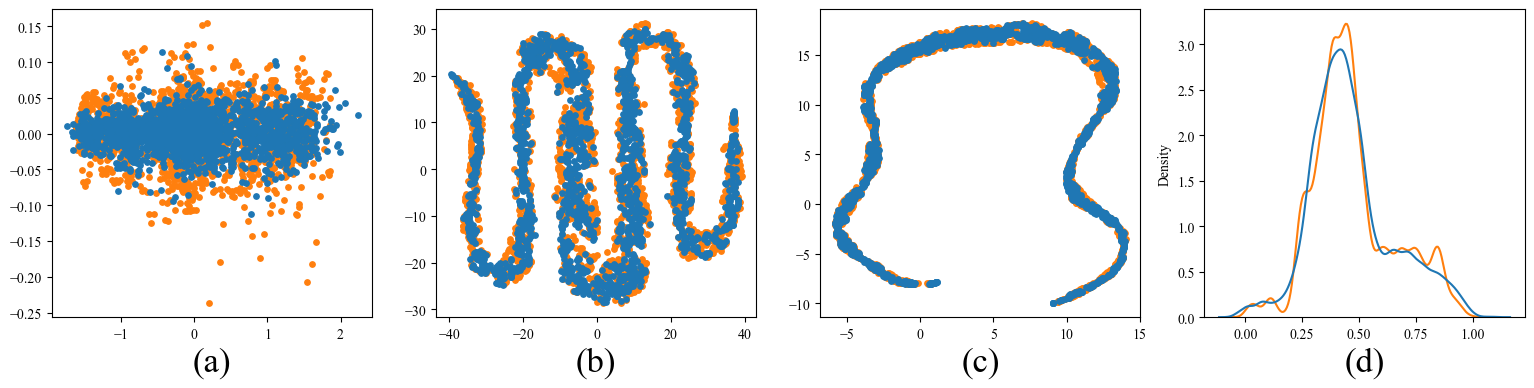

In [29]:
visualization2(train_data, x_t.detach().cpu().numpy() )

# synthesis in few-step by shortcut-ts

In [30]:
eps = 1e-8
shape = (Numble, Length, Feature)
b, c, n, = x_t.shape
padding_masks = torch.ones(b, c, dtype=bool, device=device)

res_list2 = []
for n_steps in[1,3,5,10]:
    x_t = torch.randn(shape, device=device)
    d = torch.tensor(1 / n_steps).to(device)
    t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)
    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
        d_batch = d.unsqueeze(0).repeat((b,))
        with torch.no_grad():
            v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

        x_t = x_t + (t[i] - t[i - 1]) * v_pred
    
    res_list2.append(x_t.detach().cpu().numpy())

print(len(res_list2))

4


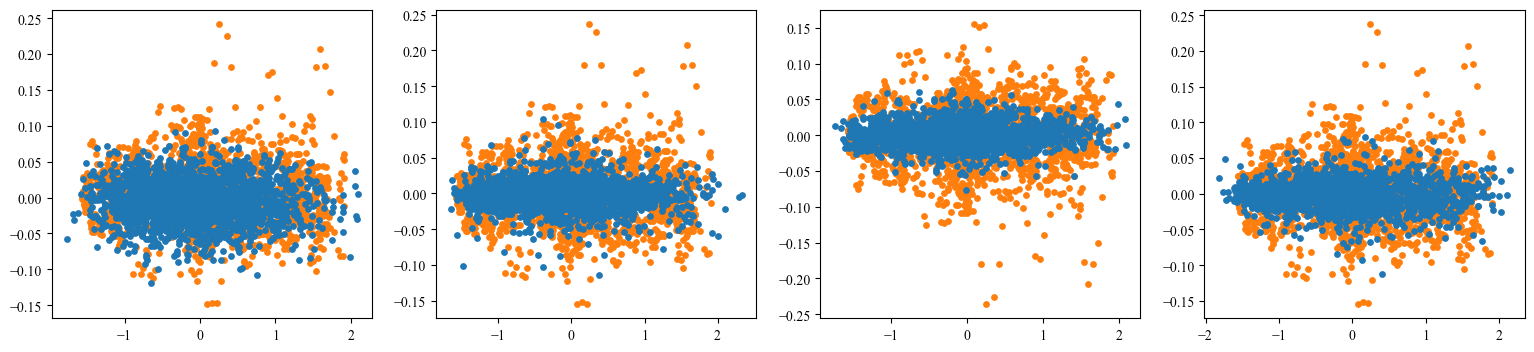

In [31]:
visualization3(train_data, res_list2)